In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [02:07<00:00, 59.7MB/s]
100% 5.20G/5.20G [02:07<00:00, 43.6MB/s]


In [ ]:
!ls

kaggle.json  sample_data  skin-cancer-mnist-ham10000.zip


In [ ]:
!unzip skin-cancer-mnist-ham10000.zip

In [ ]:
import pandas as pd
import numpy as np
#import keras
#from keras import backend as K

import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.utils import to_categorical,normalize
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall
from keras import regularizers
from glob import glob
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [ ]:
import os
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join( '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Load The Dataset

In [ ]:
df = pd.read_csv(os.path.join('HAM10000_metadata.csv'))
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
9364,HAM_0007445,ISIC_0024734,nv,consensus,25.0,male,foot,HAM10000_images_part_1/ISIC_0024734.jpg,Melanocytic nevi,4
3958,HAM_0001500,ISIC_0025527,nv,follow_up,65.0,male,lower extremity,HAM10000_images_part_1/ISIC_0025527.jpg,Melanocytic nevi,4
958,HAM_0005898,ISIC_0033553,bkl,consensus,80.0,female,back,HAM10000_images_part_2/ISIC_0033553.jpg,Benign keratosis-like lesions,2
8440,HAM_0002298,ISIC_0031483,nv,histo,25.0,male,lower extremity,HAM10000_images_part_2/ISIC_0031483.jpg,Melanocytic nevi,4
6947,HAM_0006747,ISIC_0029254,nv,histo,50.0,male,face,HAM10000_images_part_1/ISIC_0029254.jpg,Melanocytic nevi,4
4659,HAM_0007154,ISIC_0024719,nv,follow_up,70.0,male,upper extremity,HAM10000_images_part_1/ISIC_0024719.jpg,Melanocytic nevi,4
1886,HAM_0000169,ISIC_0032960,mel,histo,NaN,male,face,HAM10000_images_part_2/ISIC_0032960.jpg,Melanoma,5
5593,HAM_0006504,ISIC_0031098,nv,follow_up,55.0,female,lower extremity,HAM10000_images_part_2/ISIC_0031098.jpg,Melanocytic nevi,4
7271,HAM_0005127,ISIC_0026384,nv,histo,55.0,female,chest,HAM10000_images_part_1/ISIC_0026384.jpg,Melanocytic nevi,4
8253,HAM_0003833,ISIC_0031149,nv,histo,75.0,female,lower extremity,HAM10000_images_part_2/ISIC_0031149.jpg,Melanocytic nevi,4


EDA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


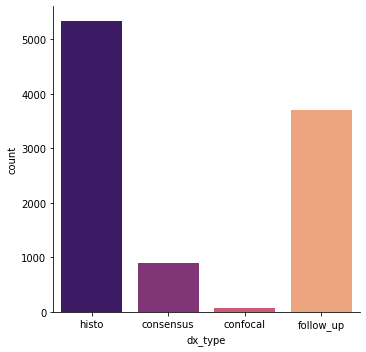

In [ ]:
import seaborn as sns
sns.catplot(x="dx_type", kind="count", palette="magma", data=df);

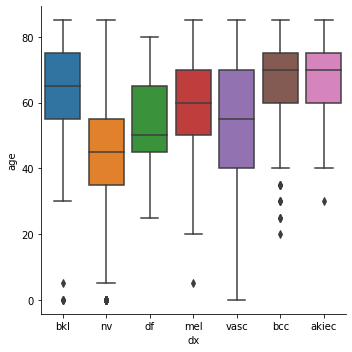

In [ ]:
sns.catplot(x="dx", y="age", kind="box", data=df);

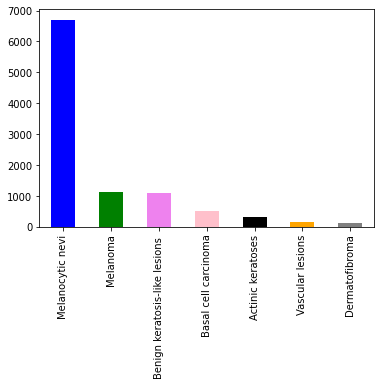

In [ ]:
df['cell_type'].value_counts().plot(kind='bar', color = ['blue','green','violet','pink','black','orange','grey','brown'])

Check Missing Values

In [ ]:
df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

Fill The Missing Values

In [ ]:
df['age'].fillna((df['age'].median()), inplace=True)

In [ ]:
from PIL import Image
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,HAM10000_images_part_2/ISIC_0033084.jpg,Actinic keratoses,0,"[[[155, 137, 148], [154, 136, 147], [151, 134,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,HAM10000_images_part_2/ISIC_0033550.jpg,Actinic keratoses,0,"[[[5, 6, 4], [6, 7, 4], [7, 8, 6], [7, 7, 5], ..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,HAM10000_images_part_2/ISIC_0033536.jpg,Actinic keratoses,0,"[[[112, 102, 105], [127, 116, 117], [141, 127,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,HAM10000_images_part_2/ISIC_0032854.jpg,Actinic keratoses,0,"[[[159, 122, 146], [159, 123, 141], [154, 112,..."


Split The Data

In [ ]:
features = df["image"]
target = df["cell_type_idx"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.1, random_state = 999)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.165, random_state = 999)
print("Shape of entire dataset: {}".format(str(features.shape)))
print("Shape of train data: {}".format(str(X_train.shape)))
print("Shape of test data: {}".format(str(X_test.shape)))
print("Shape of val data: {}".format(str(X_val.shape)))

Shape of entire dataset: (10015,)
Shape of train data: (7525,)
Shape of test data: (1002,)
Shape of val data: (1488,)


In [ ]:
l = ["train","val","test"]

for x in l:
    globals()["X_{}".format(x)] = np.asarray(globals()["X_{}".format(x)].tolist())
    globals()["X_{}_mean".format(x)] = np.mean(globals()["X_{}".format(x)])
    globals()["X_{}_std".format(x)] = np.std(globals()["X_{}".format(x)])
    globals()["X_{}".format(x)] = (globals()["X_{}".format(x)]-globals()["X_{}_mean".format(x)])/globals()["X_{}_std".format(x)]

In [ ]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)
y_val = to_categorical(y_val, num_classes = 7)

In [ ]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
X_train = X_train.reshape(X_train.shape[0], *(75, 100, 3))
X_test = X_test.reshape(X_test.shape[0], *(75, 100, 3))
X_val = X_val.reshape(X_val.shape[0], *(75, 100, 3))

In [ ]:
input_shape = (75, 100, 3)
num_classes = 7

Build Model CNN

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape=input_shape ,padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape=input_shape ,padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, kernel_size = (3,3), activation='relu', input_shape=input_shape ,padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, kernel_size = (3,3), activation='relu', input_shape=input_shape ,padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, kernel_size = (3,3), activation='relu', input_shape=input_shape ,padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, kernel_size = (3,3), activation='relu', input_shape=input_shape ,padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation='softmax'), 
  
])

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

Reviewing CNN model

In [ ]:

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 100, 64)       1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 100, 64)       256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 100, 64)       36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 50, 128)       512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 128)       1

In [ ]:
data_generator=ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')

In [ ]:
data_generator.fit(X_train)

Training CNN

In [ ]:


checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = 'modelb.h5', verbose = 1, save_best_only = True)

history = model.fit(X_train,y_train,
        batch_size = 32,
        epochs=25,
        validation_data=(X_val, y_val),
        callbacks = [checkpointer],
        verbose=2, shuffle=True)

Epoch 1/25

Epoch 00001: val_loss improved from inf to 0.88694, saving model to modeli.h5
236/236 - 9s - loss: 1.0830 - accuracy: 0.6473 - val_loss: 0.8869 - val_accuracy: 0.7050
Epoch 2/25

Epoch 00002: val_loss improved from 0.88694 to 0.82731, saving model to modeli.h5
236/236 - 8s - loss: 0.8463 - accuracy: 0.6957 - val_loss: 0.8273 - val_accuracy: 0.7130
Epoch 3/25

Epoch 00003: val_loss did not improve from 0.82731
236/236 - 8s - loss: 0.7790 - accuracy: 0.7102 - val_loss: 1.0865 - val_accuracy: 0.6573
Epoch 4/25

Epoch 00004: val_loss did not improve from 0.82731
236/236 - 8s - loss: 0.7269 - accuracy: 0.7289 - val_loss: 0.8714 - val_accuracy: 0.6956
Epoch 5/25

Epoch 00005: val_loss improved from 0.82731 to 0.82448, saving model to modeli.h5
236/236 - 8s - loss: 0.8060 - accuracy: 0.7102 - val_loss: 0.8245 - val_accuracy: 0.7097
Epoch 6/25

Epoch 00006: val_loss improved from 0.82448 to 0.75838, saving model to modeli.h5
236/236 - 8s - loss: 0.7480 - accuracy: 0.7270 - val_loss

In [ ]:
model.load_weights('model2.hdf5')
score = model.evaluate(X_train, y_train, verbose=1)
print('\n', 'Train accuracy:', score[1])
score1 = model.evaluate(X_val, y_val, verbose=1)
print('\n', 'Validation accuracy:', score1[1])

Check The Accuracy

In [ ]:
model.load_weights('modelb.h5')
score = model.evaluate(X_train, y_train, verbose=1)
print('\n', 'Train accuracy:', score[1])
score1 = model.evaluate(X_val, y_val, verbose=1)
print('\n', 'Validation accuracy:', score1[1])

236/236 [==============================] - 2s 10ms/step - loss: 0.3588 - accuracy: 0.8731

 Train accuracy: 0.8730897307395935
47/47 [==============================] - 0s 9ms/step - loss: 0.6922 - accuracy: 0.7587

 Validation accuracy: 0.7587365508079529


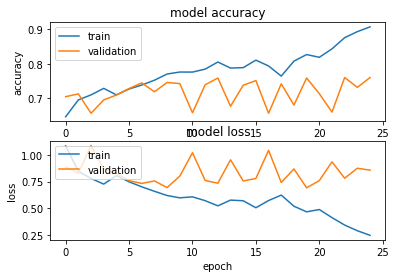

In [ ]:
plt.figure(1)  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('modelb.h5') 

In [ ]:
model_json = model.to_json()
with open("modelb.json", "w") as json_file:
    json_file.write(model_json)